[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iwmihq/dt-use-cases/blob/ce9165841a833af8d777d523b9f50f3fd8ba6f5b/python_notebook/Limpopo_river_basin/use_cases/03_water_availability_estimation.ipynb)


# ESTIMATION OF WATER AVAILABILITY IN SPECIFIC CHANNEL OF LRB
* **Products used:**
[ndvi_anomaly](https://explorer.digitalearth.africa/ndvi_anomaly), incremental_channel_contributions_limpopo, monthly rainfall, crop_mask

# Background

Background

The Limpopo River Basin (LRB), spanning four countries—Zimbabwe, Botswana, Mozambique, and South Africa—frequently faces episodes of extreme water scarcity. For communities in the basin that rely heavily on agriculture, the efficient use and management of water resources is crucial.

As part of a key CGIAR initiative, the International Water Management Institute (IWMI) is developing a Digital Twin (DT) of the Limpopo River Basin. A Digital Twin is a dynamic virtual model that mirrors real-world systems by integrating real-time data, AI, and simulation tools to enhance decision-making. The goal is to enable data-driven, adaptive, and proactive water management strategies in the region.

One critical component of this Digital Twin is the estimation of water availability across the river channels using the SWAT (Soil and Water Assessment Tool) model. This component provides monthly simulations of inflows and outflows for each channel. From these simulations, the incremental flow (net change) in each channel is calculated and classified to generate alert levels for potential water stress or surplus.

This notebook supports the project by visualizing Normalized Difference Vegetation Index (NDVI) and rainfall conditions in and around the areas flagged with alerts, helping stakeholders better understand environmental conditions contributing to changes in water availability.

## Description

The following steps were undertaken to analyze alert-flagged areas within the Limpopo River Basin:

1 **Channel selection** - Identify and select a channel of interest within the alert-flagged region.

2 **Associated Channels Mapping** - Determine all channels associated with the selected alert area.

3 **Outflow Analysis** - Visualize both the current observed outflow and forecasted outflow for the upcoming months for the selected channel.

4 **Rainfall Evaluation** - Compute and visualize the average rainfall and rainfall anomaly in the selected area to understand precipitation patterns influencing the alert.
***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Install packages" cell.

In [1]:
pip install datacube pystac_client odc-stac xvec rioxarray GDAL wapordl --quiet

## Load packages

In [2]:
%matplotlib inline

import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import xvec
import pystac_client
import datacube
import requests
import matplotlib.dates as mdates
import plotly.graph_objects as go
import xarray as xr

from osgeo import gdalnumeric, gdal
from odc.stac import configure_rio, stac_load
from datacube.utils.masking import mask_invalid_data
from datetime import datetime
from dateutil.relativedelta import relativedelta
from IPython.display import HTML
from pystac_client import Client
from odc.stac import configure_rio, stac_load
from geopy.distance import geodesic  # For accurate distance over Earth's surface
from shapely.geometry import Point

# INPUTS & ANALYZING PARAMETERS

This notebook can be used to visualize the monthly water availability(actual+forecast) time series for a specific channel. The critical channel to be monitor can be identified/selected interms of Rasterized average monthly incremental channel contributions simulated by SWAT. This stimulation is generated by IWMI which runs in every midmonth.

The user needs to define the month of interest to visualize the incremental flows in LRB.

In [3]:
#user input
observation_month = "2024-10"

start_date = observation_month + "-01"
observation_date = datetime.strptime(observation_month, "%Y-%m").date()
new_date = observation_date + relativedelta(months=12)
new_date_str = new_date.strftime("%Y-%m-%d")

# CONNECTING TO IWMI-DT-ODC

IWMI data is stored on S3 in Cape Town, Africa. To load the data, we must configure rasterio with the appropriate AWS S3 endpoint. This can be done with the odc.stac.configure_rio function. Documentation for this function is available at [https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.configure_rio.html#odc.stac.configure_ri]

In [4]:
os.environ['AWS_S3_ENDPOINT'] = 's3.af-south-1.amazonaws.com'
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
os.environ['AWS_DEFAULT_REGION'] = 'af-south-1'
os.environ['AWS Access Key ID'] = ''

In [5]:
# Set the URL of the STAC catalog you wish to query
url = 'https://odc-explorer.digitaltwins.demos-only.iwmi.org/stac'

# Initialize a STAC client to interact with the specified STAC catalog
catalog = pystac_client.Client.open(url)

# Specify the collections to retrieve
collections = ['incremental_channel_contributions_limpopo']

# # Build a query with the previously set parameters to search the STAC catalog
query = catalog.search(
    collections=collections, datetime=f"{observation_month}/{observation_month}"
)

# Fetch the items
items = list(query.items())

items

[<Item id=36eec54f-6815-4933-ad9b-3f8efd277a96>]

In [6]:
crs = "EPSG:4326"
ds = stac_load(
    items,
    crs=crs,
    chunks={},)

first_timestep = ds.LegendIndex.sel(time=observation_month,method='nearest')

## Selectin the location in the alert region

The incremental flow is generated from SWAT stimulation. the incremental flow is classified as below:

1.   **(0-1)** - high positive contribution

2.   **(1-2)** - medium positive contribution

3.   **(2-3)** - low positive contribution

4.   **(3-4)** - no contribution

5.   **(4-5)** - low negative contribution

6.   **(5-6)** - medium negative contribution

7.   **(6-7)** - high negative contribution


In [7]:
# Extract coordinates and data
lat = first_timestep.latitude.values
lon = first_timestep.longitude.values
z = first_timestep.values

# Create heatmap plot
fig = go.Figure(data=go.Heatmap(
    z=z,
    x=lon,  # longitude on x-axis
    y=lat,
    colorscale='Viridis',
    colorbar=dict(title="incremental flow Index", thickness=15)
))

# Update layout
fig.update_layout(
    title=f"Incremental flow data in LRB on {observation_month} ",

    xaxis_title="Longitude",
    yaxis_title="Latitude",
    width=1000,
    height=800
)

fig.show()

# ➡️ Feed the selected location details below ⬇️

From the above figure the critical channels can be identified (green - yellow) which gives negetive contribution to the channel. Approximate longitude and latitude need to be selected and fed in next steps to calculate the water availability.



In [8]:
lat ,lon = -25.71503,27.29267

In [9]:
buffer_lat, buffer_lon = 0.1, 0.1
output_crs = 'epsg:6933'
lon_range = (lon - buffer_lon, lon + buffer_lon)
lat_range = (lat + buffer_lat, lat - buffer_lat)

bbox = [lon_range[0], lat_range[0], lon_range[1], lat_range[1]]

In [10]:
# Load shapefile
shp = gpd.read_file('data/swat_channel_.shp')
target_point = (lat, lon)

# Function to compute geodesic distance between target and each row
def compute_distance(row):
    return geodesic((row['latitude'], row['longitude']), target_point).meters

# Compute distance column
shp['distance_m'] = shp.apply(compute_distance, axis=1)

# Get the row with minimum distance
closest_row = shp.loc[shp['distance_m'].idxmin()]

# Print closest result
print("Closest river details:")
print(closest_row)

Closest river details:
channel_id                                       cha1367
channel_na                                           Hex
latitude                                      -25.792267
longitude                                      27.252775
geometry      POINT (27.2527746792686 -25.7922671018475)
distance_m                                   9446.506782
Name: 271, dtype: object


## Downloading and visualizing rainfall event around the selected channel

## CONNECTING TO DE Africa -ODC

In this step, CHIRPS monthly rainfall data is downloaded from the Digital Earth Africa (DE Africa) platform for the selected analysis period. Since CHIRPS provides only historical data, there is no data available for the forecast period, resulting in an empty dataset for that timeframe and graph

In [11]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)
catalog_dea = Client.open("https://explorer.digitalearth.africa/stac")


In [12]:
collections = ['rainfall_chirps_monthly']

In [13]:
query =catalog_dea.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{new_date_str}")
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 7 datasets


In [14]:
ds = stac_load(
    items,
    bbox=bbox,
    resolution=30,chunks={},)

## SWAT flow visualization along with CHIRPS rainfall data

the SWAT flow data is obrtained from IWMI digitaltwin plateform .

<ipython-input-15-0df41ac53171>:12: DeprecationWarning:

dropping variables using `drop` is deprecated; use drop_vars.



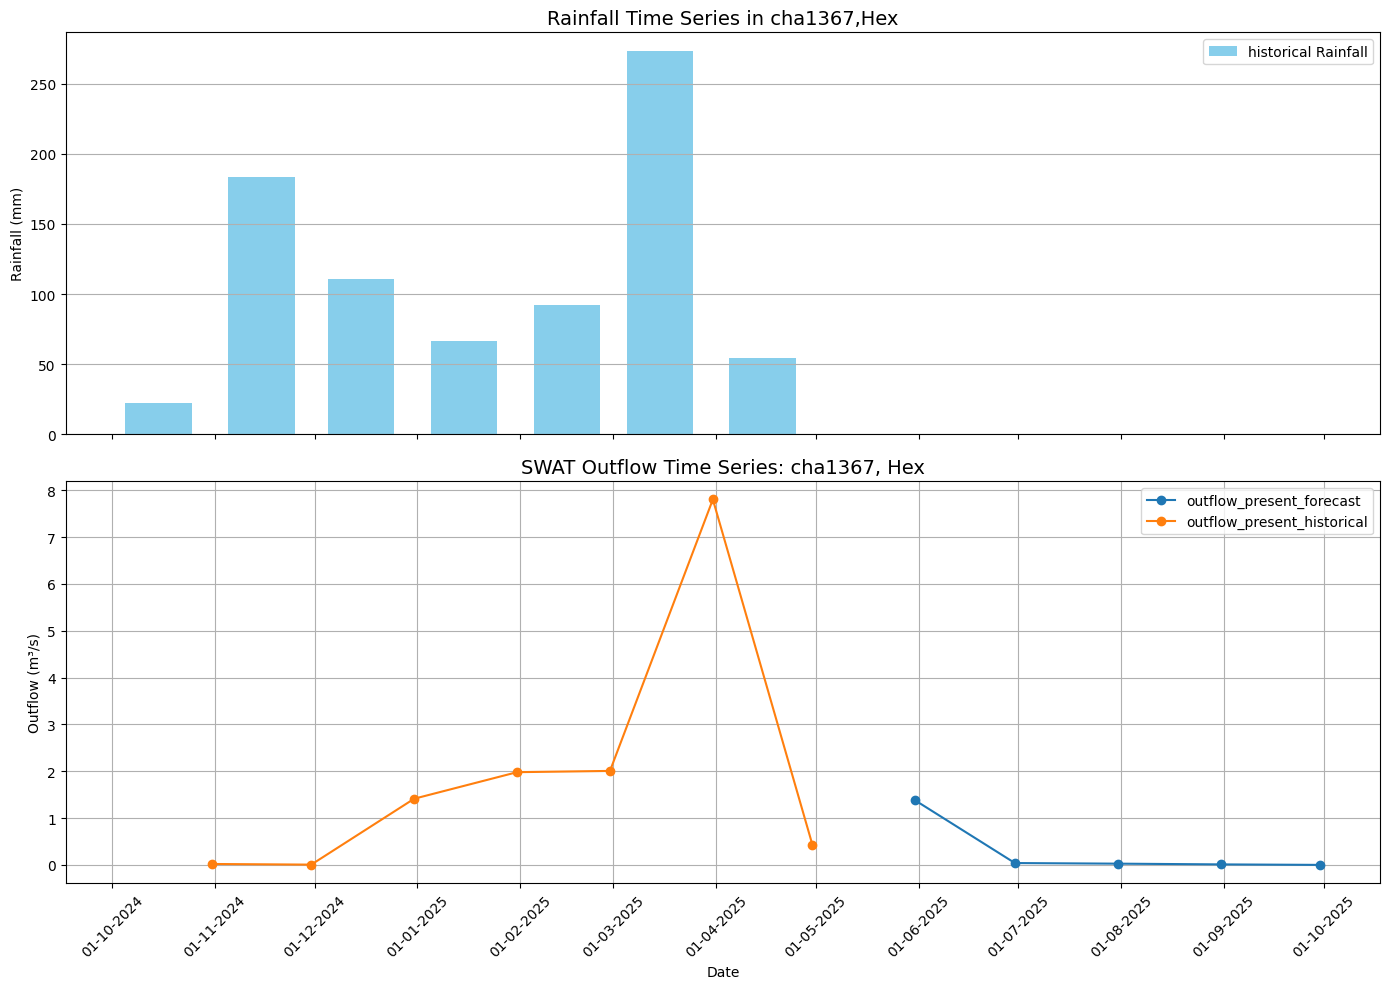

In [15]:
URL = f"https://digitaltwins.demos-only.iwmi.org/api2/data_requests/swat_present?swat_channel={closest_row['channel_id']}&start_date={start_date}&end_date={new_date_str}"
response = requests.get(URL)
data = response.json()
df = pd.DataFrame(data)

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Melt DataFrame for plotting
df_melted = df.melt(id_vars='date', value_vars=['outflow_present_historical', 'outflow_present_forecast'],
                    var_name='Type', value_name='Outflow')
ds_mean = ds.mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe().reset_index()
ds_mean['time'] = pd.to_datetime(ds_mean['time'])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# --- Top Plot: Rainfall (Bar Graph) ---
ax1.bar(ds_mean['time'], ds_mean['rainfall'], width=20, color='skyblue', label='historical Rainfall')
ax1.set_title(f"Rainfall Time Series in {closest_row['channel_id']},{closest_row['channel_na']}", fontsize=14)
ax1.set_ylabel('Rainfall (mm)')
ax1.grid(True, axis='y')
ax1.legend()

# --- Bottom Plot: SWAT Outflow ---
for key, grp in df_melted.groupby('Type'):
    ax2.plot(grp['date'], grp['Outflow'], marker='o', label=key)

ax2.set_title(f"SWAT Outflow Time Series: {closest_row['channel_id']}, {closest_row['channel_na']}", fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Outflow (m³/s)')
ax2.grid(True)
ax2.legend()

# Format x-axis
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

## Reference
- Garcia Andarcia, M., Dickens, C., Silva, P., Matheswaran, K., & Koo, J. (2024). Digital Twin for management of water resources in the Limpopo River Basin: a concept. Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 4p.https://hdl.handle.net/10568/151898

- Chambel-Leitão, P.; Santos, F.; Barreiros, D.; Santos, H.; Silva, Paulo; Madushanka, Thilina; Matheswaran, Karthikeyan; Muthuwatta, Lal; Vickneswaran, Keerththanan; Retief, H.; Dickens, Chris; Garcia Andarcia, Mariangel. 2024. Operational SWAT+ model: advancing seasonal forecasting in the Limpopo River Basin. Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 97p. https://hdl.handle.net/10568/155533

📧 **Contact:**
- Kayathri Vigneswaran
    *[v.kayathri@cgiar.org]*  
- Surajit Ghosh
    *[s.ghosh@cgiar.org]*  

In [16]:
print(datacube.__version__)

1.9.4


In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-06-10'